%%latex
\tableofcontents

# Introduction

This project deals with the problem of reconstructing 3D object depths from stereo images, that is, finding the depth of each pixel in a scene photographed by two rectified cameras and constructing a depth map.

The main concept that allows the calculation of depth is *disparity*, or how far apart a point is from its corresponding pixel in the other image. The closer the point is to the camera, the higher the disparity. The rectification assumption limits the size of the problem considerably, so that each point of one image has its equivalent in the same row of the other image.

This project demonstrates two methods for solving this problem, one is tha naïve method of calculating the disparity for each pixel through sum of squared differences, which is extremely local and inaccurate, and the second method relies on a more sophisticated —albeit slower— approach using approximate inference posed as a max-flow problem that implements the GraphCut Stereo Reconstruction algorithm proposed by Kolmogorov and Zabih \cite{kol14} .

The dataset used is the 2005 batch of 2-view, third-size images from the Middlebury Stereo Dataset \cite{mid05} .

In [4]:
# general
from src.utils import *
import os
import time
# computation and vision
import cv2
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
# graph modules
import gco
import maxflow

C:\ProgramData\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.8' currently installed).
  warnings.warn(msg, UserWarning)


In [5]:
dataset = './dataset-2005/'
left_images, right_images = load_image(dataset)
img_num = len(left_images)
print(left_images.keys())

dict_keys(['Art', 'Books', 'Dolls', 'Laundry', 'Moebius', 'Reindeer'])


In [6]:
dmax = {
    'Art': 80,
    'Books': 90,
    'Dolls': 110,
    'Laundry': 100,
    'Moebius': 100,
    'Reindeer': 100
}

In [34]:
view_images(left_images, right_images)

# SSD Method

## Algorithm and Implementation
For each pixel *p* in the left image ($I_l$), we find the 'closest' match *q* on the same row of the right image ($I_r$). The distance is measured by the SSD (Sum of Squared Differences).
$$ SSD_{t,x}(r,c) = \sum_{i=0}^{rows} \sum_{j=0}^{cols} [t(i,j) - x(r+i-\frac{rows}{2}, c+j-\frac{cols}{2})]^2 $$

The disparity *d* of p is the difference in column number of *p* and *q*, with *q* minimizing SSD. Use of a window minimizes the false matches by accounting for similar neighbours. Search depth specifies the maximum range the algorithm searches for a match in a row, defined by `search_depth`.

For each disparity level *d* up to `search_depth`, the SSD is computed for each pixel in the left image (save for the *d* edge pixels) while shifting the right image by *d* columns. The minimum SSD for each pixel is saved, and in the end, the disparity label is the minimum SSD for each pixel.

In [4]:
from scipy import ndimage
def ssd_stereo(left, right, window_size=7, search_depth=30, visualize=False):
    left, right = pair2grey(left, right)
    kernel = np.ones((window_size, window_size), np.float32)

    min_ssd = np.full(left.shape, float('inf'), dtype=np.float32)
    labels = np.zeros(left.shape, dtype=np.int)
    for i in range(search_depth):
        shift_right = right if i == 0 else right[:, :-i]
        raw_ssd = np.square(left[:, i:] - shift_right)
        ssd = ndimage.filters.convolve(raw_ssd, kernel, mode='constant', cval=0)
        label_min = ssd < min_ssd[:, i:] 
        min_ssd[:, i:][label_min] = ssd[label_min]
        labels[:, i:][label_min] = i
        if visualize:
            cv2.imshow('overlay', raw_ssd)
            cv2.waitKey(5)
    cv2.destroyAllWindows()
    return labels

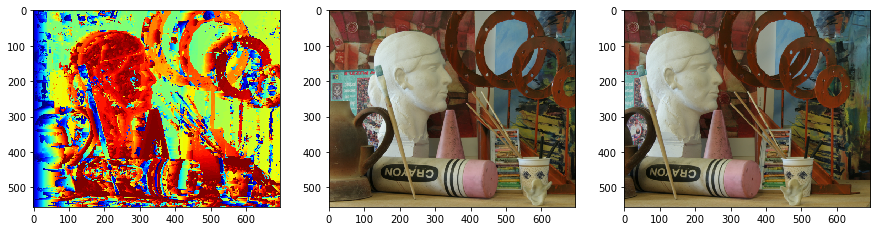

In [5]:
labels = ssd_stereo(left_images['Art'], right_images['Art'], window_size=5, search_depth=dmax['Art'], visualize=False)
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(disp2jet(labels))
axs[1].imshow(cv2.cvtColor(left_images['Art'], cv2.COLOR_BGR2RGB), cmap='gray')
axs[2].imshow(cv2.cvtColor(right_images['Art'], cv2.COLOR_BGR2RGB), cmap='gray')
plt.show()

In [6]:
# ssd_df = pd.DataFrame(columns=['Image', 'Method', 'Search Depth', 'Time'])
# or open previous run data
ssd_df = pd.read_csv('../output/ssd_df.csv')

In [17]:
disp = {}
ssd_time = {}
for k in left_images.keys():
    start = time.time()
    disp[k] = ssd_stereo(left_images[k], right_images[k], search_depth=dmax[k])
    ssd_time[k] = time.time() - start

## Results
This method is very fast, though the results are far from perfect. It also fails to address occlusion and shadows, which causes large areas to be mislabelled.

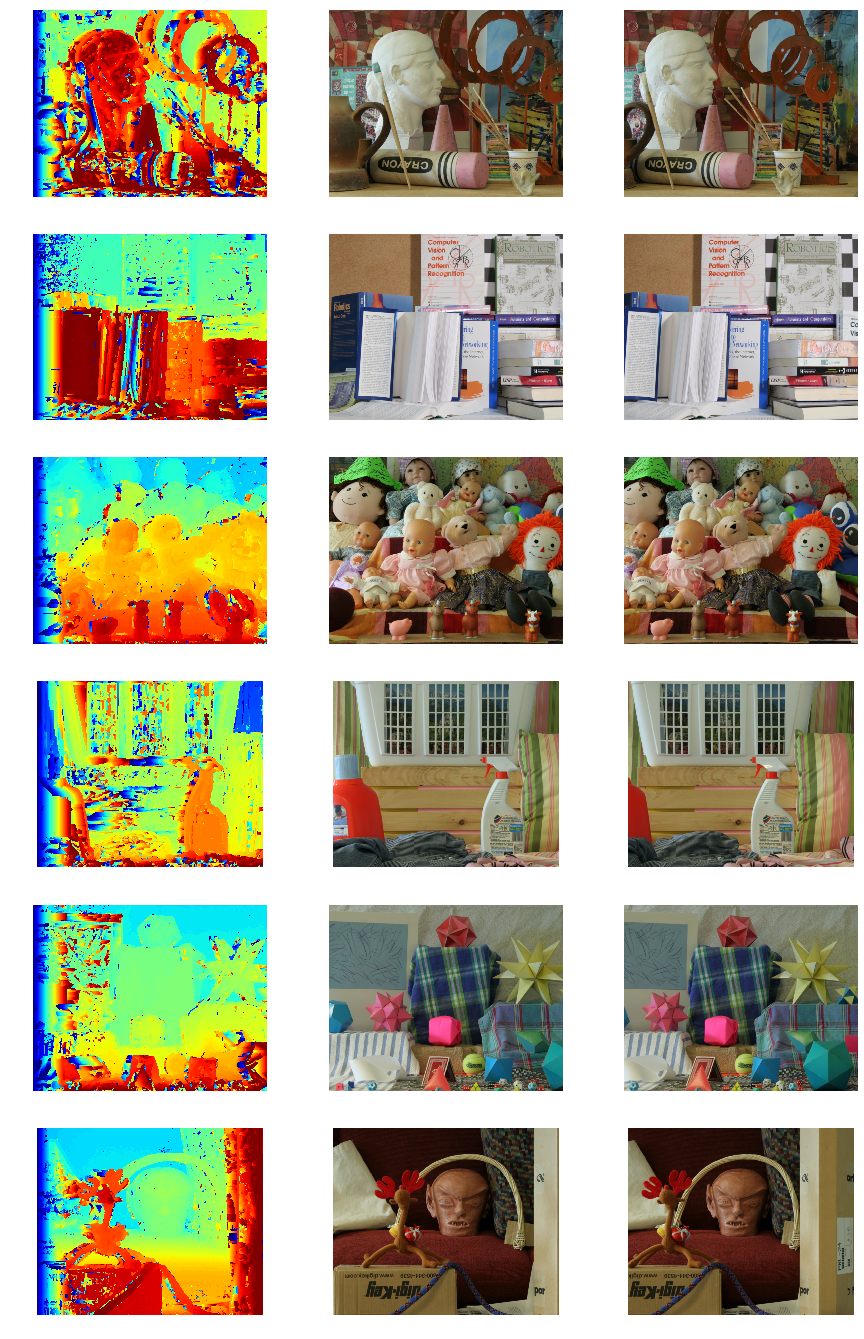

In [21]:
fig, axs = plt.subplots(img_num, 3, figsize=(15, 4*img_num))
for i, k in enumerate(left_images.keys()):
    cv2.imwrite(f'../output/{k}_ssd_{dmax[k]}_7_grey.png', disp2grey(disp[k]))
    axs[i, 0].imshow(disp2jet(disp[k]))
    axs[i, 0].axis('off')
    axs[i, 1].imshow(cv2.cvtColor(left_images[k], cv2.COLOR_BGR2RGB), cmap='gray')
    axs[i, 1].axis('off')
    axs[i, 2].imshow(cv2.cvtColor(right_images[k], cv2.COLOR_BGR2RGB), cmap='gray')
    axs[i, 2].axis('off')
plt.show()

In [25]:
for k in left_images.keys():
    ssd_df.loc[len(ssd_df)] = {'Method': 'SSD', 'Image': k, 'Time': ssd_time[k], 'Search Depth': dmax[k]}
# export to csv
ssd_df.to_csv('../output/ssd_df.csv', index=False)

In [26]:
ssd_df

,Image,Method,Search Depth,Time
0,Art,SSD,80,1.762000
1,Books,SSD,90,1.917058
2,Dolls,SSD,110,3.291009
3,Laundry,SSD,100,2.390820
4,Moebius,SSD,100,2.622073
5,Reindeer,SSD,100,2.294886


# Graph-Cut

This approach, as described by Kolmogorov and Zabih \cite{kol14}, takes into account local and global disparities instead of per-pixel calculations, resulting in better uniformity in the objects and more accuracy.


## Definition
Let $I_l$ and $I_r$ be the left and right images, respectively, and $p$ a pair of coordinates in $I_l$. The disparity of $p$ is the difference in column number of $p$ and the corresponding pixel in $I_r$. 

Assume $q$ is a pixel in $I_r$ that potentially corresponds to $p$. A configuration is any map $f : A → \{0, 1\}$. If $a = (p, q)$ is an assignment, then $f(a) = 1$ means that *p* and *q* correspond under the configuration $f$. Such assignments are called *active* assignments and $d_f(p) = p-q$. If, on the other hand, $f(a) = 0$ then the assingment is *inactive*. If $p$ has no active assignment under $f$, then it has not been matched with any pixel in $I_r$, and is considered *occluded* in $f$.

Alternatively, inspecting the graph from inference point of view\cite{jiprob}, if the variable sets **X** and **Y** are the pixels of a row in $I_l$ and $I_r$ respectively and **$D$** is the disparity map where each $d_i$ can take a value from $[1, dmax]$, the MAP inference problem is then formulated as:
$$ d^* = \arg \max_{\scriptsize{d}} p(\mathbf{d}|\mathbf{x},\mathbf{y}) $$

## Algorithm and Implementation
Assuming the problem as energy minimization, the energy term for configuration $f$ will be determined by four parameters:
   
   1. **Data Term** ($E_{data}$): the agreement of data (original images) with the disparity, here defined as square difference of pixel values. 
   
   2. **Occlusion Term** ($E_{occ}$): for pixels that are *occluded* in either of the images, meaning no disparity value is assigned. It is undesirable to label toomany pixels as occluded, so the penalty for occlusion is given by `occ_cost`.
   
   3. **Smoothness Term** ($E_{smooth}$): for adjacent pixels with similar grey value, the disparity is expected to be low, allowing for more uniformity in objects. A `smooth_cost` controls the weight term, as well as a thresholding for similarity `smooth_thresh`.
   
   4. **Uniqueness Term** ($E_{unique}$): multiple pixels in the left image should not be assigned to the same pixel in the right view, this term manages such occurances by assigning *infinite* value.

$$ E(f) = E_{data}(f) + E_{occ}(f) + E_{smooth}(f) + E_{unique}(f) $$

With energy function defined, minimizing $E$ can be viewed as a min-cut/max-flow graph-cut problem, and solved as such. Doing so over the disparity values (up to `dmax`) and finding the optimal disparity for each pixel will construct the stereo mapping.

For each $d_i$, a graph is constructed such that:

+ Two terminal nodes, *Source* and *Sink*, are defined, to which every other node is connected.

+ Each node in the graph (save for the two terminals), is a disparity assingment to a pixel. These nodes are categorised in two groups:

    1. **Label**: assignments to current $d_i = \alpha$ under expansion.

    2. **Active**: active assignments to the corresponding pixel where $d_{active} \neq \alpha$.

+ Edges represent energy, where:

  + between terminal and non-terminal nodes, $E_{data}, E_{occ}$ and $E_{smooth}$ are present.

  + between any two non-terminal nodes, only $E_{unique}$ and $E_{smooth}$ appear, as these two are local parameters.

+ Cost of each cut is the sum of the all edge weights removed in the cut. So a min-cut minimizes $E$.

In [200]:
# gc_df = pd.DataFrame(columns=['Image', 'Method', 'Search Depth', 'Steps', 'Time', 'Occlusion Cost', 'Smoothness Threshold'])
# get from previous runs
gc_df = pd.read_csv('./output/gc_df.csv')

In [201]:
from src.graphcut import Graph_Cut_Solver
from src.utils import *

In [202]:
name = 'Books'
max_steps = dmax[name]//2
occ_cost = 200
smooth_thresh = 10
# down-scaling to speed up computation
left = cv2.resize(left_images[name], (0, 0), fx=0.5, fy=0.5)
right = cv2.resize(right_images[name], (0, 0), fx=0.5, fy=0.5)
solver = Graph_Cut_Solver(left, right, search_depth=dmax[name]//2, occ_cost=occ_cost, max_steps=max_steps, smooth_thresh=smooth_thresh)

d:\Afarin\Edu\Year 4\Probabilistic Graphical Models\stereo\src\graphcut.py:48: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  left_diff = self.left[list(idx_p)] - self.left[list(idx_q)]


In [203]:
start = time.time()
gc_labels = solver.solve()
gc_time = time.time() - start

Label order in iteration 0: [-16 -42 -44  -1 -33  -2 -40 -22 -12 -41 -37 -45   0 -21 -17 -14 -43  -3
 -39 -24 -23  -7 -13 -18  -9 -20 -15  -8 -26 -19 -29 -11 -38 -32 -31 -28
  -6 -25 -27 -35 -36  -5 -30  -4 -34 -10]


d:\Afarin\Edu\Year 4\Probabilistic Graphical Models\stereo\src\graphcut.py:139: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  p_labels, q_labels = self.labels[self.neighbours_roll]
d:\Afarin\Edu\Year 4\Probabilistic Graphical Models\stereo\src\graphcut.py:201: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  diff_right = self.right[list(p_idx_shifted)] - self.right[list(q_idx_shifted)]


Iteration 0 time: 267.9714295864105
----------------------------------------


In [204]:
gc_df.loc[len(gc_df)] = {'Method': 'GC', 'Image': name, 'Time': gc_time, 'Search Depth': dmax[name]//2,
 'Steps': max_steps, 'Smoothness Threshold': smooth_thresh, 'Occlusion Cost': occ_cost}
gc_df.to_csv('./output/gc_df.csv', index=False)

In [215]:
gc_disp = disp2grey(gc_labels)
cv2.imwrite(f'./output/{name}_gc_{dmax[name]}_{max_steps}_{occ_cost}_{smooth_thresh}.png', gc_disp)

True

## Results
This algorithm takes considerably more time to run than the window-based SSD method, but it is more robust to occlusions and noise. The testcases are based on the half-sized images for better performance, and only performed on 'Art' sample. The parameters whose effects are studied are number of disparity levels (steps) allowed within the search depth, occlusion cost, and smoothness threshold.
The results are shown below.

In [206]:
gc_df

,Image,Method,Search Depth,Steps,Time,Occlusion Cost,Smoothness Threshold
0,Art,GC,40,10,223.909211,200,30
1,Art,GC,40,40,792.406955,200,30
2,Art,GC,40,20,397.426273,200,30
3,Art,GC,40,20,406.447656,200,10
4,Art,GC,40,20,369.897651,20,10
5,Art,GC,40,40,780.397735,200,10
6,Dolls,GC,55,55,944.261157,200,10
7,Reindeer,GC,50,50,836.978975,200,10
8,Laundry,GC,50,50,1168.911556,200,10
9,Moebius,GC,50,50,943.044941,200,10


Even the perliminary results are much better than the window-based SSD method, and the smoothness term and uniqueness cause more accurate and smooth surfaces, with trade-off on both time and memory, however.

It can be seen that the maximum number of disparity levels allowed have significant effect on both time (as they increase the iterations of maxflow) and accuracy. Too few disparity levels cause errors, as seen in the image with `max_steps = 10`.

The high occlusion cost causes more accurate matches instead of false occlusion patches (e.g. in `occ_cost=20`). Too high cost will cause false negatives, however.

The smoothness threshold has a similar effect, for a high enough smoothing threshold, the disparity map is more accurate and smooth, but if the threshold is too high, the disparity map will detect false areas as smooth and incur the smoothness cost on them, sometimes causing incorrect depths (as seen in `smooth_thresh=30`).

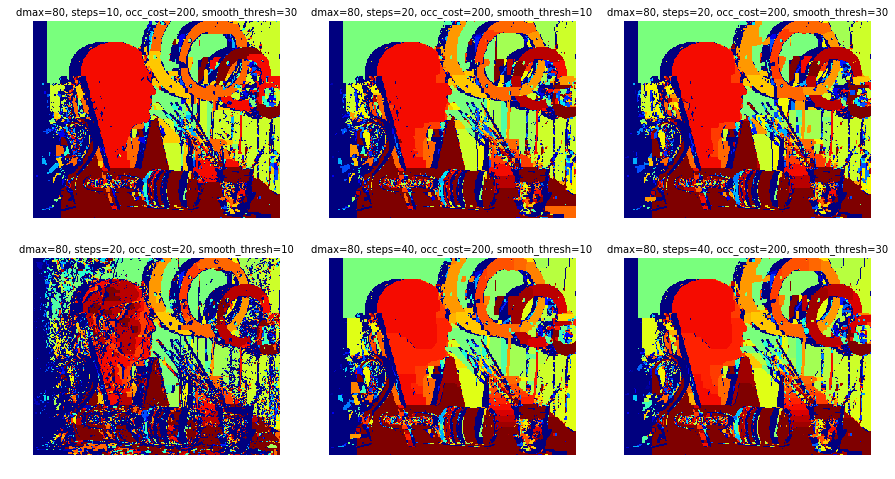

In [170]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
gc_disp = {}

for file in os.listdir('./output/'):
    if file.startswith('Art_gc'):
        gc_disp[file] = (cv2.imread(f'./output/{file}', cv2.IMREAD_GRAYSCALE))

for i, k in enumerate(gc_disp.keys()):
    info = k.split('_')
    info[5] = info[5][:-4]
    axs[i//3, i%3].imshow(gc_disp[k], cmap='jet')
    axs[i//3, i%3].axis('off')
    axs[i//3, i%3].set_title(f'dmax={info[2]}, steps={info[3]}, occ_cost={info[4]}, smooth_thresh={info[5]}', fontsize=10)
plt.show()


The other images are processed using the configuration:  `max_steps=dmax`, `occ_cost=200`, `smooth_cost=40`, `smooth_thresh=10`.

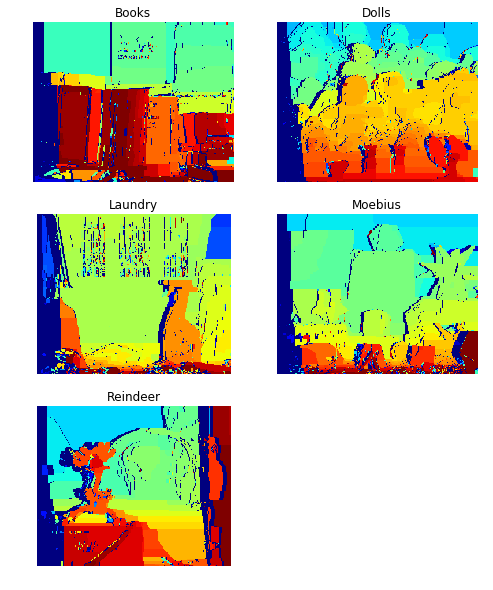

In [211]:
fig, axs = plt.subplots(3, 2, figsize=(8, 10))
gc_disp = {}

for file in os.listdir('./output/'):
    if 'gc' in file and '.png' in file and not 'Art' in file:
        name = file.split('_')[0]
        gc_disp[name] = (cv2.imread(f'./output/{file}', cv2.IMREAD_GRAYSCALE))

for i, k in enumerate(gc_disp.keys()):
    axs[i//2, i%2].imshow(gc_disp[k], cmap='jet')
    axs[i//2, i%2].axis('off')
    axs[i//2, i%2].set_title(k)
axs[2,1].axis('off')
plt.show()


<!--bibtex
@article{kol14
    title   = {{Kolmogorov and Zabih’s Graph Cuts Stereo Matching Algorithm}},
    author  = {Kolmogorov, Vladimir and Monasse, Pascal and Tan, Pauline},
    journal = {{Image Processing On Line}},
    volume  = {4},
    pages   = {220--251},
    year    = {2014},
    note    = {\url{https://doi.org/10.5201/ipol.2014.97}}
}
@book{jiprob,
  title={Probabilistic Graphical Models for Computer Vision},
  author={Ji, Q.},
  isbn={9780128034675},
  url={https://books.google.fr/books?id=6\_vDDwAAQBAJ},
  year={2019},
  publisher={Elsevier Science \& Technology}
}
@misc{mid05
author = {Blasiak, Anna and Wehrwein, Jeff and Scharstein, Daniel},
title = {{Middlebury Stereo Datasets},
year = {2005},
url = {https://vision.middlebury.edu/stereo/data/scenes2005/}
} 
-->

# Loopy Belief Propagation
Similar to GC, by modelling the problem as an MRF with observed variables being the pixel intensities and the hidden variables being the disparity map, the approximate inference can be solved using Loopy Belief Propagation (LBP). By using negative log probabilities, max-product becomes min-sum, which is less sensitive to numerical artefacts \cite{Fel2006}.

## Definition and Algorithm
The energy term that would be minimized is defined as:
$$\mathbf{E} = \sum_{p}{D(d_p)} + \lambda . \sum_{p,q\in\mathcal{N}}{S(d_p, d_q)}$$
where $d_p$ is the disparity level assigned to pixel $p$, $\mathcal{N}$ is the set of edges connecting neighbouring pixels, $D$ is the data cost term, and $S$ is the smoothness term (cost of disparity difference in neighbouring pixels), weighted by $\lambda$.

Data cost function, also known as unary energy, returns the cost of assigning a label $d$ to pixel $p$, which should be low for good matches and high otherwise. In this case, the data cost function is defined as follows:
$$D(d_p) = \min(\parallel I_L(x, y) - I_R(x-d_p, y)\parallel, \tau)$$
where $I_L$ and $I_R$ are the intensity values of the left and right images, respectively, and $x$ and $y$ are the coordinates of the pixel.

At each iteration, messages are computed in the following way:
$$m^t_{pq}(d_p) = \min_{d_p}(D(d_p) + S(d_p, d_q) + \sum_{s\in\mathcal{N}(p)/q}{m^{t-1}_{sp}(d_p)})$$
where $\mathcal{N}(p)/q$ denotes the neighbours of $p$ excluding $q$. After $T$ iterations, a beleief vector is computed for each node:
$$b_q(d_q) = D(d_q) + \sum_{p\in\mathcal{N}(q)}{m^T_{pq}(d_q)}$$

Finally, the label $d^*_q$ that would minimize the node belief is selected individually for each node, creating the disparity map.

## Implementation
Each iteration consists of four steps:

1. **Data Cost Calculation**: $D(d_p)$ is calculated for each pixel $p$ and each disparity level $d_p$, using the formula above. The patameter `tau` is used to control the maximum cost, which is by default set to 10.

2. **Update Messages**: the update phase is performed as described above, and the messages are normalized in the end.

3. **Compute Beliefs**: $b_q$ is calculated using the updated messages.

4. **Select Labels**: $d^*_q$ is selected for each node $q$ using the belief vector.

Other parameters that control the algorithm are `max_disp` which sets the maximum level of disparity, `max_iter` which sets the number of iterations, and `smooth_weight` which corresponds to $\lambda$.

In [190]:
from src.utils import *
from src.loopy_bp import LoopyBP

In [181]:
# lbp_df = pd.DataFrame(columns=['Image', 'Method', 'Search Depth', 'Iterations', 'Time'])
# or import from csv
lbp_df = pd.read_csv('./output/lbp_df.csv')

In [197]:
name = 'Art'
max_steps = dmax[name]//2
max_iter = 60
# down-scaling to speed up computation
left = cv2.resize(left_images[name], (0, 0), fx=0.5, fy=0.5)
right = cv2.resize(right_images[name], (0, 0), fx=0.5, fy=0.5)
solver = LoopyBP(left, right, max_disp=max_steps, max_iter=max_iter)

In [ ]:
start = time.time()
labels, energy = solver.solve_bp()
lbp_time = time.time() - start

In [122]:
lbp_df.loc[len(lbp_df)] = {'Method': 'LBP', 'Image': name, 'Time': lbp_time, 'Search Depth': dmax[name]//2,
 'Iterations': max_iter}
lbp_df.to_csv('./output/lbp_df.csv', index=False)

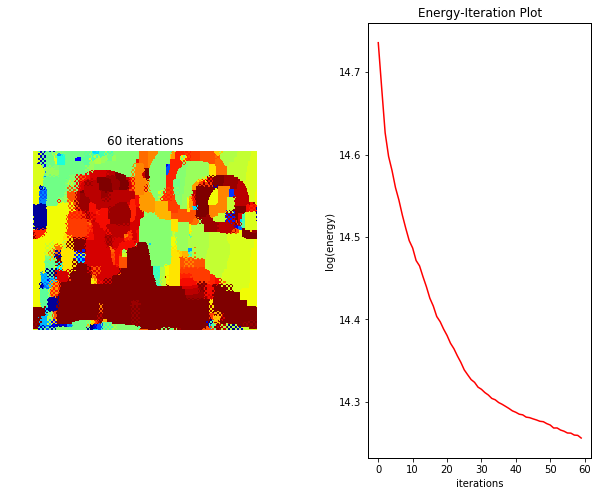

In [216]:
plt.figure(figsize=(10, 8))
# set plt margins
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.imshow(disp2jet(labels))
plt.title(f'{max_iter} iterations')
plt.axis('off')

plt.subplot(122)
plt.plot(np.log(energy), 'r')
plt.xlabel('iterations')
plt.ylabel('log(energy)')
plt.title('Energy-Iteration Plot')
plt.show()

In [106]:
cv2.imwrite(f'./output/{name}_lbp_{dmax[name]}_{max_iter}.png', disp2grey(labels))

True

## Results

As shown in the energy plot, more iterations lead to a closer convergence to zero, however they also take longer. For the sake of efficiency, the number of iterations for other testcases is set to 30.

By increasing the smoothness weight, the image becomes extremely patchy (e.g. `smooth_weight=20`), which renders the disparity map nearly useless.

In [229]:
lbp_df

,Image,Method,Search Depth,Iterations,Time
0,Art,LBP,40,30,60.254125
1,Art,LBP,40,10,23.482555
2,Art,LBP,40,60,106.665385
3,Art,LBP,40,100,156.847903
4,Books,LBP,45,30,38.643798
5,Dolls,LBP,55,30,46.088910
6,Laundry,LBP,50,30,38.433630
7,Moebius,LBP,50,30,35.759749
8,Reindeer,LBP,50,30,36.000189


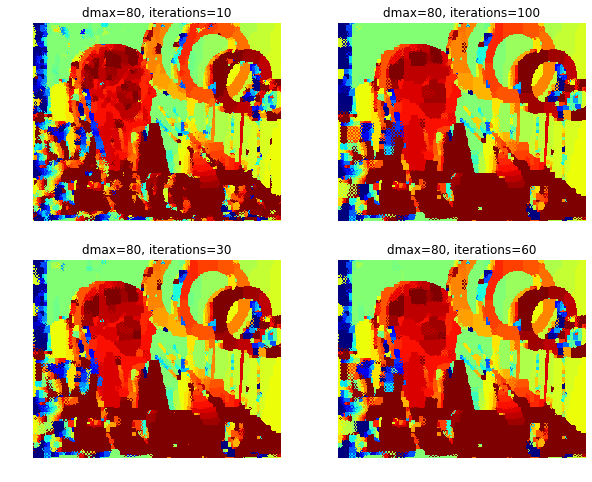

In [213]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
lbp_disp = {}

for file in os.listdir('./output/'):
    if file.startswith('Art_lbp'):
        lbp_disp[file] = (cv2.imread(f'./output/{file}', cv2.IMREAD_GRAYSCALE))

for i, k in enumerate(lbp_disp.keys()):
    info = k.split('_')
    info[3] = info[3][:-4]
    axs[i//2, i%2].imshow(lbp_disp[k], cmap='jet')
    axs[i//2, i%2].axis('off')
    axs[i//2, i%2].set_title(f'dmax={info[2]}, iterations={info[3]}', fontsize=12)
plt.show()

# Conclusion
Among the three methods, given the trade-off of time and accuracy, the Loopy Belief Propagation method is the most accurate without being time-consuming. This method does not account for occlusion, however, and in most cases the results of graph-cut are smoother and have less 'patterned artefacts'.

Generally, the results are greatly dependant on the input image. For example, *Art* testcase is best solved using GC, but *Dolls* are better represented using LBP. The repetetive patterns in *Laundry* are best handled using GC, and the small disrepencies in *Moebius* are handled better with LBP. Interestingly, none of the testcases perform better under SSD and the time improvement is minimal in comparison to the better-performing LBP.

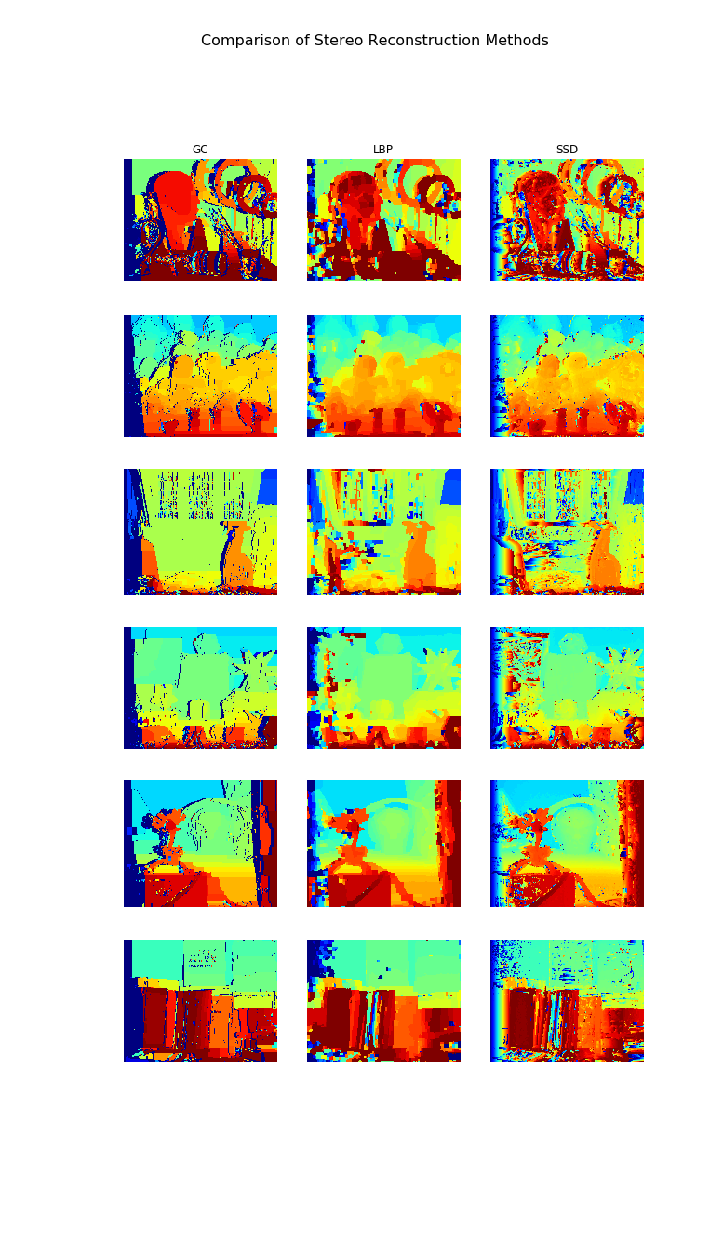

In [225]:
plt.figure(figsize=(12,25))
plt.imshow(cv2.cvtColor(cv2.imread('./output/comparison_jet.png'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

A greyscale version of the above plot is also available:

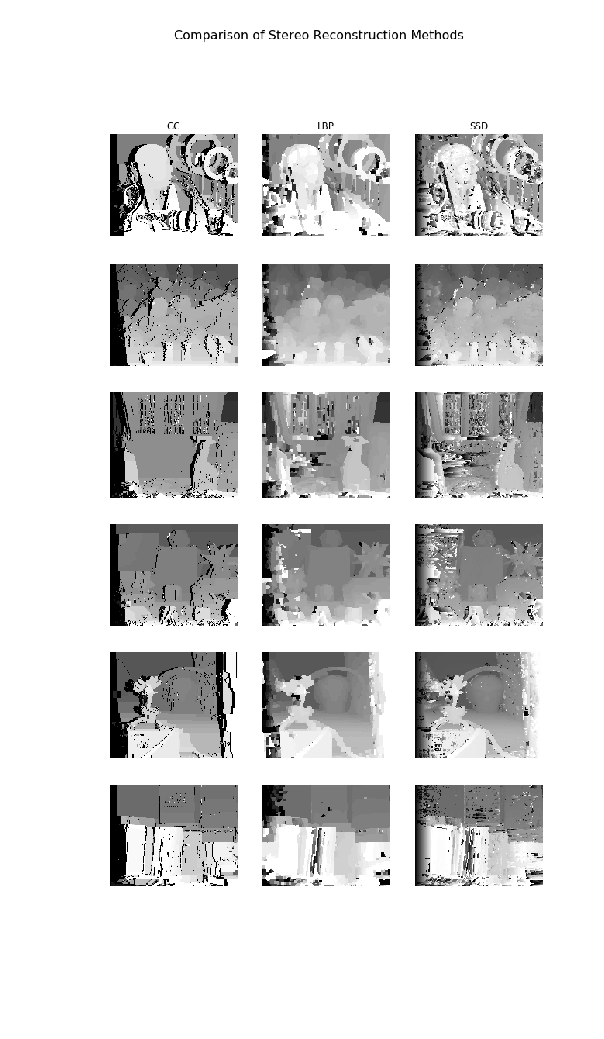

In [228]:
plt.figure(figsize=(10,20))
plt.imshow(cv2.imread('./output/comparison_grey.png'))
plt.axis('off')
plt.show()